Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.7191 - loss: 0.5822 - val_accuracy: 0.7263 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8768 - loss: 0.3199 - val_accuracy: 0.8421 - val_loss: 0.6026 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8571 - loss: 0.2654 - val_accuracy: 0.8632 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8826 - loss: 0.2085 - val_accuracy: 0.8526 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9140 - loss: 0.2027 - val_accuracy: 0.8316 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8438 - loss: 0.2854 - val_accuracy: 0.7789 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9044 - loss: 0.2388 - val_a

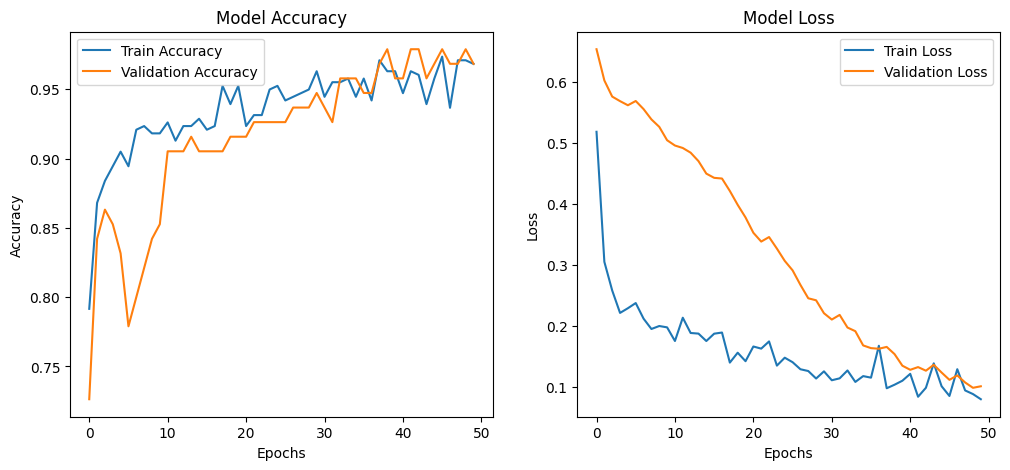

['scaler.pkl']

In [3]:
# ======= Imports =======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.combine import SMOTEENN

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import joblib

# ======= Load and Preprocess Data =======
def load_data(file_path="C:/Users/AYESHA/Downloads/stupid folder/.ipynb_checkpoints/diabetes.csv"):
    data = pd.read_csv(file_path)
    missing_value_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    data[missing_value_cols] = data[missing_value_cols].replace(0, np.nan)

    for col in ['Glucose', 'BMI']:
        data[col] = data[col].fillna(data[col].median())

    imputer = KNNImputer(n_neighbors=5)
    data[missing_value_cols] = imputer.fit_transform(data[missing_value_cols])

    X = data.drop(columns=['Outcome'])
    y = data['Outcome']
    return X, y

# ======= Balance and Scale Data =======
def balance_and_scale_data(X, y):
    smoteenn = SMOTEENN()
    X_resampled, y_resampled = smoteenn.fit_resample(X, y)

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    return X_resampled, y_resampled, scaler

# ======= Split and Reshape Data =======
def split_and_reshape_data(X_resampled, y_resampled):
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train_reshaped, X_test_reshaped, y_train, y_test

# ======= Create BiLSTM Model =======
def create_model(input_dim):
    model = Sequential([
        Input(shape=(1, input_dim)),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ======= Train Final Model =======
def train_final_model(X_train_reshaped, y_train):
    final_model = create_model(X_train_reshaped.shape[2])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    final_history = final_model.fit(
        X_train_reshaped, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    return final_model, final_history

# ======= Evaluate Model =======
def evaluate_model(final_model, final_history, X_test_reshaped, y_test):
    # ======= Training Accuracy =======
    training_metrics = final_history.history
    if 'accuracy' in training_metrics:
        final_train_accuracy = training_metrics['accuracy'][-1] * 100
    elif 'acc' in training_metrics:
        final_train_accuracy = training_metrics['acc'][-1] * 100
    else:
        final_train_accuracy = None

    # ======= Predictions =======
    y_test_pred_proba = final_model.predict(X_test_reshaped)
    y_test_pred = (y_test_pred_proba > 0.45).astype("int32")

    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # ======= Results =======
    print(f"Final Training Accuracy: {final_train_accuracy:.2f}%" if final_train_accuracy is not None else "Training accuracy not found.")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    print(f"Final Test Precision: {precision * 100:.2f}%")
    print(f"Final Test Recall: {recall * 100:.2f}%")
    print(f"Final Test F1 Score: {f1 * 100:.2f}%")
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# ======= Plot Training History =======
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# ======= Run Everything =======
X, y = load_data()
X_resampled, y_resampled, scaler = balance_and_scale_data(X, y)
X_train_reshaped, X_test_reshaped, y_train, y_test = split_and_reshape_data(X_resampled, y_resampled)

final_model, final_history = train_final_model(X_train_reshaped, y_train)
evaluate_model(final_model, final_history, X_test_reshaped, y_test)
plot_training_history(final_history)

# ======= Save Model and Scaler =======
final_model.save("diabetes_bilstm_model.h5")
joblib.dump(scaler, 'scaler.pkl')


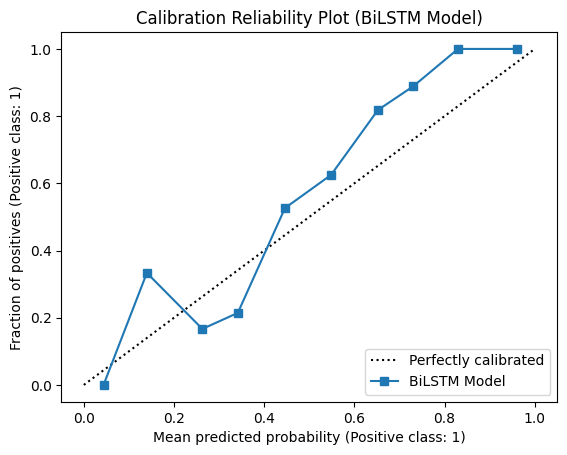

In [3]:
# --- MISSING SETUP CODE GOES HERE ---
# Example: (You'd replace this with your actual data and model)
import numpy as np
from sklearn.model_selection import train_test_split

# Assume 'X' and 'y' are your features and labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# For demonstration, creating placeholder data:
np.random.seed(42)
N = 100
# y_test: True labels (e.g., 0 or 1)
y_test = np.random.randint(0, 2, N)
# y_pred_proba: Predicted probabilities for the positive class
y_pred_proba = np.clip(np.random.normal(0.5, 0.2, N) + (y_test - 0.5) * 0.3, 0.01, 0.99)
# -----------------------------------

from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# Generate and display the calibration reliability plot
disp = CalibrationDisplay.from_predictions(
    y_test,
    y_pred_proba,
    n_bins=10,
    name="BiLSTM Model"
)

plt.title("Calibration Reliability Plot (BiLSTM Model)")
plt.savefig("Calibration_Plot_BiLSTM.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. DATA PREPARATION ---
def prepare_raw_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Check your path! System cannot find: {file_path}")
        
    df = pd.read_csv(file_path)
    
    # Identify 0s that are actually missing values (biological impossibilities)
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
    
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    return X, y

# SET YOUR PATH HERE
FILE_PATH = "C:/Users/AYESHA/Downloads/stupid folder/.ipynb_checkpoints/diabetes.csv"

X_raw, y_raw = prepare_raw_data(FILE_PATH)

# --- 2. THE SPLIT ---
# Stratify ensures the 0/1 ratio is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=42, stratify=y_raw
)

# --- 3. PREPROCESS TRAINING DATA ---
# Fit Imputer ONLY on Train
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)

# Fit Scaler ONLY on Train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Apply SMOTEENN ONLY on Train to handle class imbalance
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_scaled, y_train)

# --- 4. PREPROCESS TEST DATA ---
# CRITICAL: Use .transform(), NOT .fit_transform()
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# --- 5. RESHAPE FOR BiLSTM ---
# [samples, time_steps, features] -> here time_steps = 1
X_train_final = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_final = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# --- 6. DEFINE MODEL ---
def build_bilstm(input_dim):
    model = Sequential([
        Input(shape=(1, input_dim)),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_bilstm(X_train_final.shape[2])

# --- 7. TRAINING ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

print("Starting training...")
model.fit(
    X_train_final, y_train_resampled, 
    validation_split=0.2, 
    epochs=100, # Increased epochs since EarlyStopping is active
    batch_size=32, 
    callbacks=callbacks, 
    verbose=1
)

# --- 8. EVALUATE ---
y_pred_proba = model.predict(X_test_final)
y_pred = (y_pred_proba > 0.45).astype(int) 

print("\n--- PERFORMANCE REPORT ---")
print(f"Final Test N: {len(y_test)}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- 9. SAVE ASSETS ---
model.save("diabetes_bilstm_model.h5")
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')
print("\nModel and Preprocessors saved successfully.")

Starting training...
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.8154 - loss: 0.5639 - val_accuracy: 0.5152 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8655 - loss: 0.2912 - val_accuracy: 0.6465 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8657 - loss: 0.2516 - val_accuracy: 0.6869 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8945 - loss: 0.2699 - val_accuracy: 0.6869 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8931 - loss: 0.2180 - val_accuracy: 0.6768 - val_loss: 0.6360 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8969 - loss: 0.2274 - val_accuracy: 0.6970 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0

Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9853 - loss: 0.0723 - val_accuracy: 0.9293 - val_loss: 0.1762 - learning_rate: 5.0000e-04
Epoch 46/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9593 - loss: 0.0850 - val_accuracy: 0.9394 - val_loss: 0.1725 - learning_rate: 2.5000e-04
Epoch 47/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9736 - loss: 0.0762 - val_accuracy: 0.9394 - val_loss: 0.1679 - learning_rate: 2.5000e-04
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9731 - loss: 0.0762 - val_accuracy: 0.9394 - val_loss: 0.1650 - learning_rate: 2.5000e-04
Epoch 49/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9647 - loss: 0.0879 - val_accuracy: 0.9596 - val_loss: 0.1570 - learning_rate: 2.5000e-04
Epoch 50/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9714 - loss: 0.1009 - val_accuracy: 0.9697 - val_loss: 0.1519 - learning_rate: 2.5000e-04
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc

Epoch 88/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9576 - loss: 0.0770 - val_accuracy: 0.9596 - val_loss: 0.1349 - learning_rate: 3.1250e-05
Epoch 89/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9663 - loss: 0.0810 - val_accuracy: 0.9596 - val_loss: 0.1334 - learning_rate: 3.1250e-05
Epoch 90/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9809 - loss: 0.0448 - val_accuracy: 0.9596 - val_loss: 0.1330 - learning_rate: 3.1250e-05
Epoch 91/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9771 - loss: 0.0646 - val_accuracy: 0.9596 - val_loss: 0.1333 - learning_rate: 3.1250e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step



--- PERFORMANCE REPORT ---
Final Test N: 154
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       100
           1       0.59      0.81      0.68        54

    accuracy                           0.73       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.73      0.74       154

Confusion Matrix:
[[69 31]
 [10 44]]

Model and Preprocessors saved successfully.
